In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import skew, kurtosis


In [2]:
def get_intraday_data(ticker, interval, start_date, end_date):
    # Download stock data
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

# Usage
ticker = 'SPY'
interval = '1wk'  # Specify your desired interval here ('1m', '5m', '15m', '30m', '60m', etc.)
end_date = datetime.now()    # Adjust dates as needed
start_date = end_date - timedelta(days=252)  # Adjust dates as needed

end_date_str = end_date.strftime('%Y-%m-%d')
start_date_str = start_date.strftime('%Y-%m-%d')
print(f'--- Fetching {interval} data for {ticker} ---')
data = get_intraday_data(ticker, interval, start_date_str, end_date_str)
#print(data.head())  # Print the first few rows of the dataframe

df = data.copy()
df['candlestick_range'] = (df.High - df.Low).abs()
df['candlestick_body'] = (df.Open-df.Close).abs()
df['candlestick_wick'] = df['candlestick_range'] - df['candlestick_body']
df['candlestick_upper_wick'] = np.where(df['Open'] > df['Close'], df['High']-df['Open'], df['High']-df['Close'])
df['candlestick_lower_wick'] = np.where(df['Open'] > df['Close'], df['Close']-df['Low'], df['Open']-df['Low'])
df['candlestick_direction'] = np.where(df['Close'] > df['Open'], 1, 2)
df['percent_change'] = df['Close'].pct_change()
df['percent_change'] = df['percent_change'].fillna(0)

print(df.head())

--- Fetching 1wk data for SPY ---
[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-02-19  509.269989  510.130005  507.100006  507.850006  503.105743   
2024-02-26  508.299988  513.289978  504.750000  512.849976  508.059052   
2024-03-04  512.030029  518.219971  504.910004  511.720001  506.939606   
2024-03-11  510.480011  517.380005  508.119995  509.829987  505.067261   
2024-03-18  514.000000  524.109985  511.119995  521.210022  517.945251   

               Volume  candlestick_range  candlestick_body  candlestick_wick  \
Date                                                                           
2024-02-19   61321800           3.029999          1.419983          1.610016   
2024-02-26  316478500           8.539978          4.549988          3.989990   
2024-03-04  336114900          13.309967          0.310028

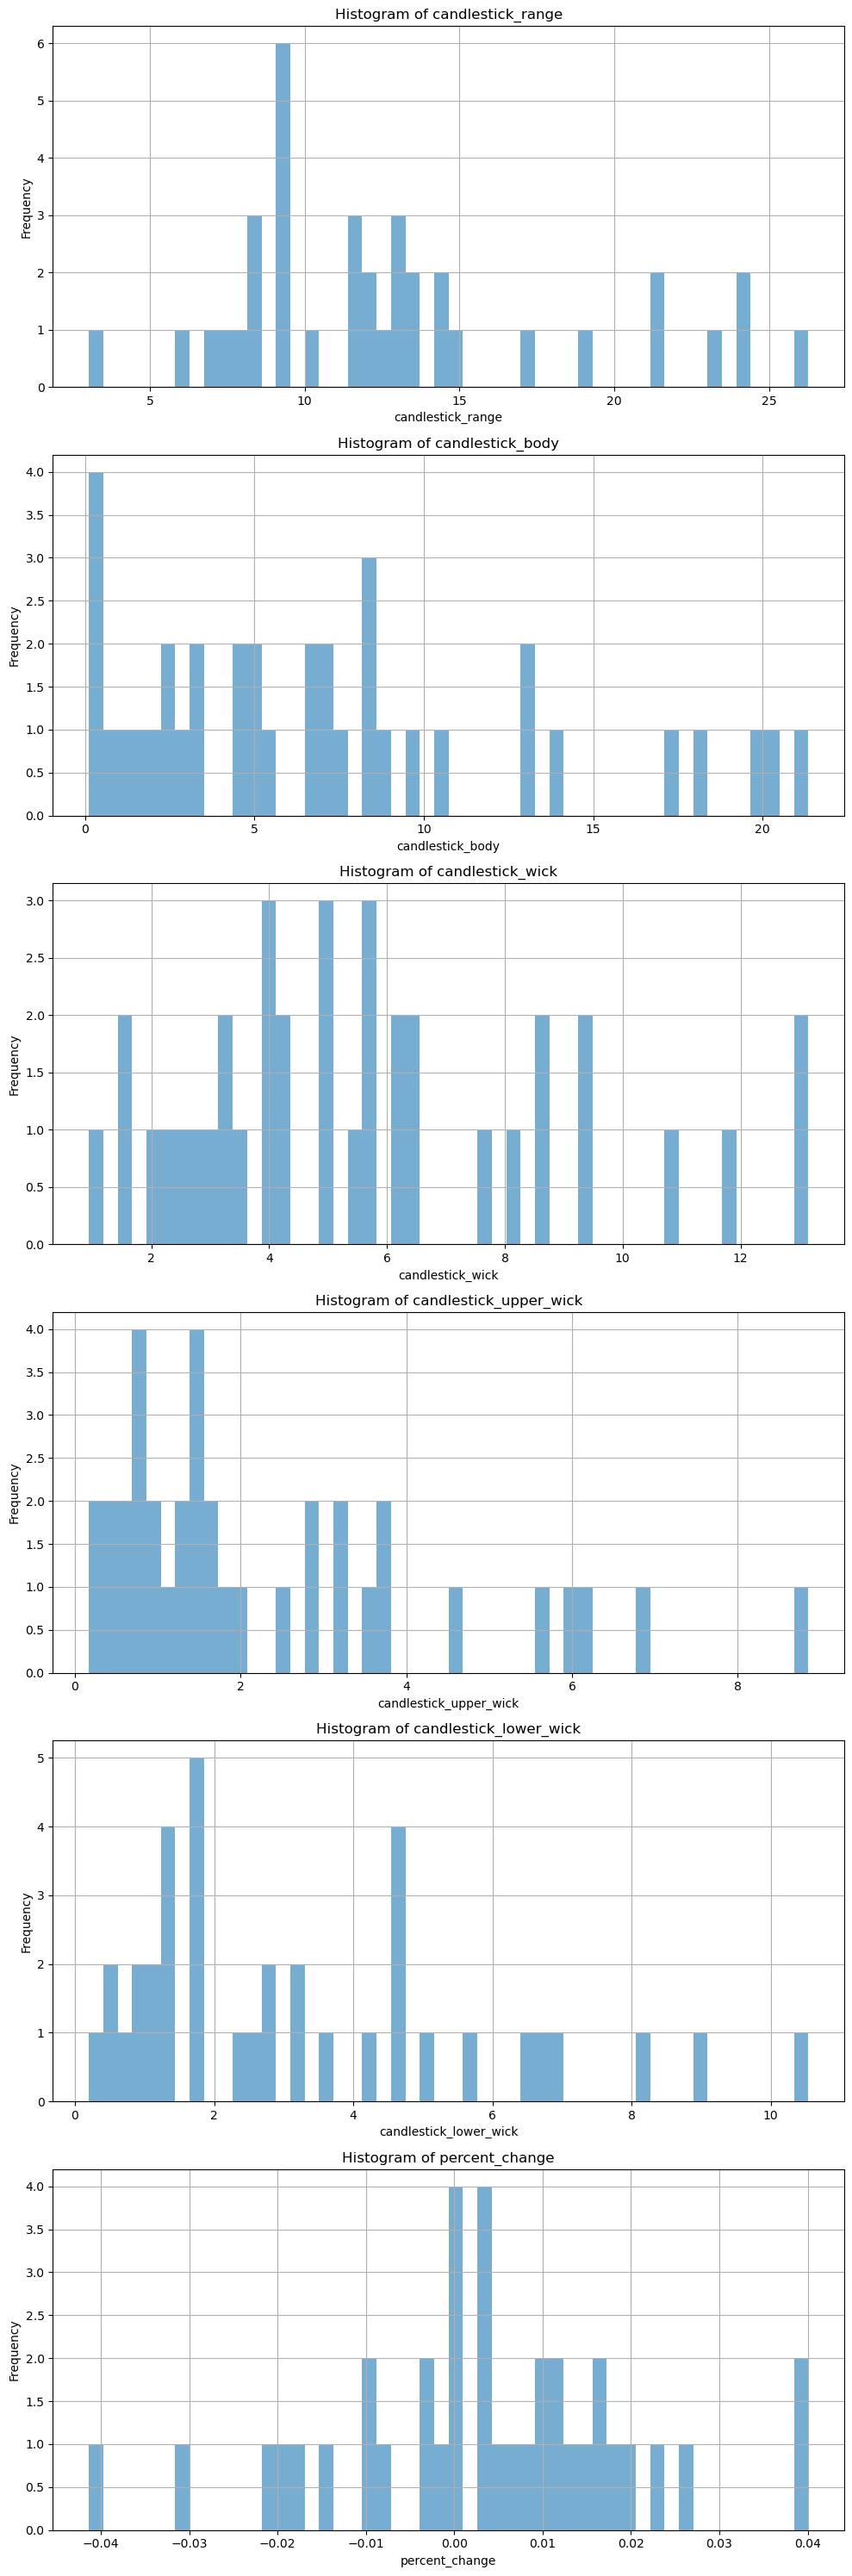

In [3]:
# Assuming df is your DataFrame and already contains the required columns

# List of the column names for which to create histograms
columns = ['candlestick_range', 'candlestick_body', 'candlestick_wick', 'candlestick_upper_wick', 'candlestick_lower_wick', 'percent_change']

# Setting up the figure and axes for the histograms
fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))

# Creating a histogram for each column
for ax, column in zip(axes, columns):
    df[column].hist(ax=ax, bins=50, alpha=0.6)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [4]:
# Assuming df is your DataFrame

# Calculate mean, median, and standard deviation using describe()
summary_stats = df.describe().T  # Transpose for easier readability
summary_stats['median'] = df.median()  # Adding median to the summary

# Calculate mode for each column
# Note: Mode can return multiple values per column if there's a tie, so taking the first one for simplicity
modes = df.mode().iloc[0]  # Taking the first mode value
summary_stats['mode'] = modes

print(summary_stats)

                        count          mean           std           min  \
Open                     37.0  5.387568e+02  2.448858e+01  4.978300e+02   
High                     37.0  5.454751e+02  2.413859e+01  5.098800e+02   
Low                      37.0  5.324565e+02  2.426278e+01  4.938600e+02   
Close                    37.0  5.401116e+02  2.440265e+01  4.951600e+02   
Adj Close                37.0  5.377649e+02  2.566082e+01  4.920584e+02   
Volume                   37.0  2.625258e+08  7.711101e+07  6.132180e+07   
candlestick_range        37.0  1.301865e+01  5.597157e+00  3.029999e+00   
candlestick_body         37.0  7.335954e+00  6.098648e+00  1.100464e-01   
candlestick_wick         37.0  5.682700e+00  3.189846e+00  9.400024e-01   
candlestick_upper_wick   37.0  2.372967e+00  2.099181e+00  1.699829e-01   
candlestick_lower_wick   37.0  3.309733e+00  2.604247e+00  2.000122e-01   
candlestick_direction    37.0  1.405405e+00  4.977427e-01  1.000000e+00   
percent_change           

In [5]:
# Assuming df is your DataFrame and it's already been loaded and prepared

# Calculate the mean and std deviation for each column
means = df.mean()
stds = df.std()

# Forecasted values at 1, 2, and 3 standard deviations from the mean
forecasted_values = pd.DataFrame(index=['+1 Std Dev', '-1 Std Dev','+2 Std Dev','-2 Std Dev','+3 Std Dev','-3 Std Dev'])

for col in df.columns:
    forecasted_values[col] = [
        means[col] + stds[col],  # +1 standard deviation
        means[col] - stds[col],  # -1 standard deviation
        means[col] + 2*stds[col], # +2 standard deviations
        means[col] - 2*stds[col], # -2 standard deviations
        means[col] + 3*stds[col], # +3 standard deviations
        means[col] - 3*stds[col]  # -3 standard deviations
    ]

print(forecasted_values)

                  Open        High         Low       Close   Adj Close  \
+1 Std Dev  563.245340  569.613722  556.719265  564.514274  563.425677   
-1 Std Dev  514.268180  521.336549  508.193699  515.708973  512.104038   
+2 Std Dev  587.733919  593.752309  580.982048  588.916924  589.086497   
-2 Std Dev  489.779601  497.197962  483.930915  491.306323  486.443219   
+3 Std Dev  612.222499  617.890895  605.244832  613.319574  614.747316   
-3 Std Dev  465.291021  473.059376  459.668132  466.903673  460.782400   

                  Volume  candlestick_range  candlestick_body  \
+1 Std Dev  3.396368e+08          18.615811         13.434602   
-1 Std Dev  1.854148e+08           7.421497          1.237306   
+2 Std Dev  4.167478e+08          24.212968         19.533250   
-2 Std Dev  1.083038e+08           1.824339         -4.861342   
+3 Std Dev  4.938588e+08          29.810125         25.631898   
-3 Std Dev  3.119276e+07          -3.772818        -10.959990   

            candlestick_w

In [6]:
# Define the ticker symbols
# Define the tickers for the ETF's top holdings and SPY
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'BRK-B', 'AVGO', 'LLY', 'SPY']

# Calculate end_date as today and start_date as 60 days before today
end_date = datetime.now()
start_date = end_date - timedelta(days=252)

# Download historical data for all tickers
data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
close_prices = data['Close'].copy()
close_prices['Total'] = close_prices.drop('SPY', axis=1).sum(axis=1)
close_prices['EGH'] = close_prices['Total'] / .3126
close_prices['PDC_EGH'] = close_prices['SPY'] / close_prices['EGH']
#print(close_prices.head())

summary_stats_close_prices = close_prices.describe().T  # Transpose for easier readability
summary_stats_close_prices['median'] = close_prices.median()  # Adding median to the summary

print(summary_stats_close_prices)

[*********************100%%**********************]  11 of 11 completed
         count          mean         std          min          25%  \
AAPL     175.0    203.969486   23.898252   165.000000   180.205002   
AMZN     175.0    182.613715    7.469067   161.020004   178.019997   
AVGO     175.0    151.076794   18.394999   120.471001   133.869003   
BRK-B    175.0    427.523658   22.782099   396.730011   408.554993   
GOOG     175.0    165.475771   13.129317   132.559998   157.949997   
GOOGL    175.0    164.021029   12.990001   131.399994   156.364998   
LLY      175.0    844.781544   71.840609   724.869995   773.000000   
META     175.0    510.318114   38.106654   430.170013   484.065002   
MSFT     175.0    422.861714   15.524680   389.329987   413.590012   
NVDA     175.0    109.720623   18.766771    76.199997    90.385502   
SPY      175.0    539.945771   24.242519   495.160004   518.764984   
Total    175.0   3182.362449  195.936870  2839.784012  2992.750992   
EGH      175.0  101

[*********************100%%**********************]  11 of 11 completed
Statistics=0.335, p-value=0.000
Sample does not look Gaussian (reject H0)
PDC_EGH_Net Skewness: 35.452361155619826
PDC_EGH_Net Kurtosis: 1742.5353992155087
PDC_EGH_Gross Skewness: 35.45236115561983
PDC_EGH_Gross Kurtosis: 1742.535399215509
                count          mean         std          min           25%  \
AAPL           3354.0    227.012018    5.199688   214.369995    223.456253   
AMZN           3354.0    185.755843    5.102335   171.460007    184.029930   
AVGO           3354.0    169.827099   11.362558   135.050507    165.362579   
BRK-B          3353.0    458.491719    6.335500   445.309998    454.660004   
GOOG           3354.0    163.596772    5.770846   148.309998    160.550003   
GOOGL          3354.0    162.209930    5.626229   147.309998    159.320007   
LLY            3353.0    906.705471   23.551121   773.090027    896.479980   
META           3354.0    560.466908   28.871563   496.399994    5

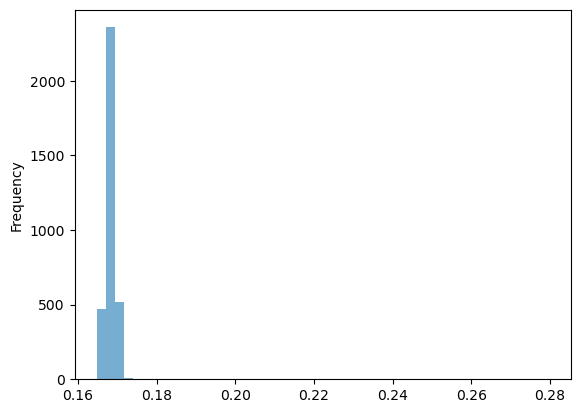

In [7]:
# Define the ticker symbols
# Define the tickers for the ETF's top holdings and SPY
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'BRK-B', 'AVGO', 'LLY', 'SPY']

# Calculate end_date as today and start_date as 60 days before today
end_date = datetime.now()
start_date = end_date - timedelta(days=59)

# Download historical data for all tickers
data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='5m')
close_prices = data['Close'].copy()
close_prices['Total'] = close_prices.drop('SPY', axis=1).sum(axis=1)
close_prices['EGH'] = close_prices['Total'] / .3126
close_prices['PDC_EGH_Net'] = close_prices['SPY'] / close_prices['Total']
close_prices['PDC_EGH_Gross'] = close_prices['SPY'] / close_prices['EGH']

# close_prices['Spread'] = close_prices['SPY'] - (close_prices['Total'] * close_prices['PDC_EGH_Net'])
#print(close_prices.head())

summary_stats_close_prices = close_prices.describe().T  # Transpose for easier readability
summary_stats_close_prices['median'] = close_prices.median()  # Adding median to the summary

stat, p_value = stats.shapiro(close_prices['PDC_EGH_Net'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p_value))
alpha = 0.05
if p_value > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


# Example data - replace this with your dataset
# data2 = np.random.normal(loc=0.01, scale=0.61, size=1000)

# Perform the Shapiro-Wilk test
# stat, p_value = stats.shapiro(data2)

# print('Statistics=%.3f, p-value=%.3f' % (stat, p_value))

# Interpretation
# alpha = 0.05
# if p_value > alpha:
#     print('Sample looks Gaussian (fail to reject H0)')
# else:
#     print('Sample does not look Gaussian (reject H0)')

# close_prices['PDC_EGH_Net'].plot(kind='hist', bins=50, alpha=0.6)
close_prices['PDC_EGH_Net'].plot(kind='hist', bins=50, alpha=0.6)
# Calculate skewness and kurtosis for 'PDC_EGH_Net' and 'PDC_EGH_Gross'
skewness_net = skew(close_prices['PDC_EGH_Net'])
kurtosis_net = kurtosis(close_prices['PDC_EGH_Net'])

skewness_gross = skew(close_prices['PDC_EGH_Gross'])
kurtosis_gross = kurtosis(close_prices['PDC_EGH_Gross'])

print(f"PDC_EGH_Net Skewness: {skewness_net}")
print(f"PDC_EGH_Net Kurtosis: {kurtosis_net}")

print(f"PDC_EGH_Gross Skewness: {skewness_gross}")
print(f"PDC_EGH_Gross Kurtosis: {kurtosis_gross}")

print(summary_stats_close_prices)

In [8]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Example tickers list provided
tickers = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'BRK-B', 'AVGO', 'TSLA', 'SPY']

# Calculate end_date as today and start_date as 60 days before today
end_date = datetime.now()
start_date = end_date - timedelta(days=59)

# Download historical data for all tickers
data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='5m')
close_prices = data['Close'].copy()

# Check if there are any missing values
missing_values = close_prices.isnull().sum().sum()
close_prices.fillna(close_prices.ffill(), inplace=True)
# If there are missing values, we'll need to handle them, but first let's see if there are any.
# print(missing_values)

# Separating independent and dependent variables
X = close_prices.drop('SPY', axis=1)
y = close_prices['SPY']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(mse, r2)

# Extracting the coefficients and the intercept
coefficients = model.coef_
intercept = model.intercept_

# Assuming 'tickers' is a list of your ticker symbols excluding 'SPY', as it's your dependent variable
# Adjust the tickers list as per your dataset
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'Meta', 'GOOGL', 'GOOG', 'BRK-B', 'AVGO', 'LLY']

# Displaying the coefficients and the intercept
# print("Intercept (beta_0):", intercept)
# for ticker, coefficient in zip(tickers, coefficients):
#     print(f"Coefficient for {ticker} (beta):", coefficient)

# Optionally, to format the prediction formula as a string
formula = f"SPY = {intercept:.4f} " + " ".join([f"+ ({coef:.4f} * {ticker})" if coef >= 0 else f"- ({abs(coef):.4f} * {ticker})" for ticker, coef in zip(tickers, coefficients)])
# print("\nPrediction Formula:\n", formula)

# Print the predicted SPY value
print(model.predict(X_test.iloc[0:1]))

[*********************100%%**********************]  11 of 11 completed
[547.22691826]


In [9]:
# Example tickers list provided
# holdings > 3% of SPY
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'SPY']

# Calculate end_date as today and start_date as 60 days before today
end_date = datetime.now()
start_date = end_date - timedelta(days=90)

# Download historical data for all tickers
data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='1d')
close_prices = data['Close'].copy()

# Check if there are any missing values
missing_values = close_prices.isnull().sum().sum()
close_prices.fillna(close_prices.ffill(), inplace=True)
# If there are missing values, we'll need to handle them, but first let's see if there are any.
print(missing_values)

# Separating independent and dependent variables
X = close_prices.drop('SPY', axis=1)
y = close_prices['SPY']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mse, r2)


# Extracting the coefficients and the intercept
coefficients = model.coef_
intercept = model.intercept_

# Assuming 'tickers' is a list of your ticker symbols excluding 'SPY', as it's your dependent variable
# Adjust the tickers list as per your dataset
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN']

# Displaying the coefficients and the intercept
print("Intercept (beta_0):", intercept)
for ticker, coefficient in zip(tickers, coefficients):
    print(f"Coefficient for {ticker} (beta):", coefficient)

# Optionally, to format the prediction formula as a string
formula = f"SPY = {intercept:.4f} " + " ".join([f"+ ({coef:.4f} * {ticker})" if coef >= 0 else f"- ({abs(coef):.4f} * {ticker})" for ticker, coef in zip(tickers, coefficients)])
print("\nPrediction Formula:\n", formula)


# Download the most recent data for the tickers
most_recent_data = yf.download(tickers, start=datetime.now().strftime('%Y-%m-%d'), interval='5m')
most_recent_close_prices = most_recent_data['Close'].iloc[-1] # Taking the last row, assuming it's the most recent

# Display most recent closing prices for verification
print("Most Recent Closing Prices:")
print(most_recent_close_prices)

# Predicting the SPY price using the most recent data
# Convert the Series to the same structure as your X data by ensuring it's in the correct DataFrame form
X_most_recent = most_recent_close_prices.values.reshape(1, -1) # Reshape it to be 2D as expected by the model

# Use the model to predict the SPY price
predicted_SPY_price = model.predict(X_most_recent)[0] # Predict returns an array, so take the first element

print(f"Predicted SPY Price: {predicted_SPY_price}")


[*********************100%%**********************]  5 of 5 completed
0
13.368078138942819 0.9633782732698325
Intercept (beta_0): 196.40415055736145
Coefficient for MSFT (beta): 0.7359602854270093
Coefficient for AAPL (beta): 1.0627424173041409
Coefficient for NVDA (beta): -0.11317254987847268
Coefficient for AMZN (beta): 0.4489391984550302

Prediction Formula:
 SPY = 196.4042 + (0.7360 * MSFT) + (1.0627 * AAPL) - (0.1132 * NVDA) + (0.4489 * AMZN)
[*********************100%%**********************]  4 of 4 completed
Most Recent Closing Prices:
AAPL    222.709000
AMZN    199.354996
MSFT    414.749908
NVDA    136.029999
Name: 2024-11-01 11:10:00-04:00, dtype: float64
Predicted SPY Price: 586.3030334731262


c:\Users\chadc\anaconda3\envs\quant-stack\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [10]:
# Example tickers list provided
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'AVGO', 'META', 'GOOGL', 'GOOG', 'TSLA', 'COST', 'QQQ']

# Calculate end_date as today and start_date as 60 days before today
end_date = datetime.now()
start_date = end_date - timedelta(days=59)

# Download historical data for all tickers
data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='5m')
close_prices = data['Close'].copy()

# Check if there are any missing values
missing_values = close_prices.isnull().sum().sum()
close_prices.fillna(close_prices.ffill(), inplace=True)
# If there are missing values, we'll need to handle them, but first let's see if there are any.
# print(missing_values)

# Separating independent and dependent variables
X = close_prices.drop('QQQ', axis=1)
y = close_prices['QQQ']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(mse, r2)


# Extracting the coefficients and the intercept
coefficients = model.coef_
intercept = model.intercept_

# Assuming 'tickers' is a list of your ticker symbols excluding 'SPY', as it's your dependent variable
# Adjust the tickers list as per your dataset
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'AVGO', 'META', 'GOOGL', 'GOOG', 'TSLA', 'COST']

# Displaying the coefficients and the intercept
# print("Intercept (beta_0):", intercept)
# for ticker, coefficient in zip(tickers, coefficients):
#     print(f"Coefficient for {ticker} (beta):", coefficient)

# Optionally, to format the prediction formula as a string
formula = f"QQQ = {intercept:.4f} " + " ".join([f"+ ({coef:.4f} * {ticker})" if coef >= 0 else f"- ({abs(coef):.4f} * {ticker})" for ticker, coef in zip(tickers, coefficients)])
# print("\nPrediction Formula:\n", formula)

# Print the predicted SPY value
print(model.predict(X_test.iloc[0:1]))

[*********************100%%**********************]  11 of 11 completed
[457.02956734]
